In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as px
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, roc_auc_score
logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Your work

#Data Description:
Notes for Tennis Data

All data is in csv format, ready for use within standard spreadsheet applications. 

Key to results data:

ATP = Tournament number (men)  
WTA = Tournament number (women)  
Location = Venue of tournament  
Tournament = Name of tounament (including sponsor if relevant)  
Data = Date of match (note: prior to 2003 the date shown for all matches played in a single tournament is the start date)  
Series = Name of ATP tennis series (Grand Slam, Masters, International or International Gold)  
Tier = Tier (tournament ranking) of WTA tennis series.  
Court = Type of court (outdoors or indoors)  
Surface = Type of surface (clay, hard, carpet or grass)  
Round = Round of match  
Best of = Maximum number of sets playable in match  
Winner = Match winner  
Loser = Match loser  
WRank = ATP Entry ranking of the match winner as of the start of the tournament  
LRank = ATP Entry ranking of the match loser as of the start of the tournament  
WPts = ATP Entry points of the match winner as of the start of the tournament  
LPts = ATP Entry points of the match loser as of the start of the tournament  
W1 = Number of games won in 1st set by match winner  
L1 = Number of games won in 1st set by match loser  
W2 = Number of games won in 2nd set by match winner  
L2 = Number of games won in 2nd set by match loser  
W3 = Number of games won in 3rd set by match winner  
L3 = Number of games won in 3rd set by match loser  
W4 = Number of games won in 4th set by match winner  
L4 = Number of games won in 4th set by match loser  
W5 = Number of games won in 5th set by match winner  
L5 = Number of games won in 5th set by match loser  
Wsets = Number of sets won by match winner  
Lsets = Number of sets won by match loser  
Comment = Comment on the match (Completed, won through retirement of loser, or via Walkover)  


Key to match betting odds data:  

B365W = Bet365 odds of match winner  
B365L = Bet365 odds of match loser  
B&WW = Bet&Win odds of match winner  
B&WL = Bet&Win odds of match loser  
CBW = Centrebet odds of match winner  
CBL = Centrebet odds of match loser  
EXW = Expekt odds of match winner  
EXL = Expekt odds of match loser  
LBW = Ladbrokes odds of match winner  
LBL = Ladbrokes odds of match loser  
GBW = Gamebookers odds of match winner  
GBL = Gamebookers odds of match loser  
IWW = Interwetten odds of match winner  
IWL = Interwetten odds of match loser  
PSW = Pinnacles Sports odds of match winner  
PSL = Pinnacles Sports odds of match loser  
SBW = Sportingbet odds of match winner  
SBL = Sportingbet odds of match loser  
SJW = Stan James odds of match winner  
SJL = Stan James odds of match loser  
UBW = Unibet odds of match winner  
UBL = Unibet odds of match loser  

MaxW= Maximum odds of match winner (as shown by Oddsportal.com)  
MaxL= Maximum odds of match loser (as shown by Oddsportal.com)  
AvgW= Average odds of match winner (as shown by Oddsportal.com)  
AvgL= Average odds of match loser (as shown by Oddsportal.com)  


Tennis-Data would like to acknowledge the following sources which are currently utilised in the compilation of Tennis-Data's results and odds files.  

Results:  
Xscores - http://www.xscores.com/  
ATPtennis.com - http://www.atptennis.com/  
ATP Tour Rankings and Results Page - http://www.stevegtennis.com/  
Livescore - http://www.livescore.net/  

Rankings:  
ATPtennis.com - http://www.atptennis.com/  
ATP Tour Rankings and Results Page - http://www.stevegtennis.com/  
WTA TOur Rankings - http://www.sonyericssonwtatour.com  

Betting odds for matches generally represent the most recent before play starts, as reported by oddsportal.com and the individual bookmakers.

In [4]:
df_atp

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.40,1.38,3.14
52294,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.22,6.03,1.17,5.14
52295,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Zverev A.,...,NaN,NaN,NaN,NaN,NaN,NaN,3.40,1.45,3.14,1.38
52296,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Djokovic N.,...,NaN,NaN,NaN,NaN,NaN,NaN,1.15,7.72,1.12,6.52


In [5]:
df_wta

,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Sun T.T.,...,1.35,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Dulko G.,...,3.75,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Loit E.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Craybas J.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Auckland,ASB Classic,2007-01-01,Tier 4,Outdoor,Hard,1st Round,3,Bartoli M.,...,1.20,4.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29576,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Muguruza G.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.05,2.06,1.88,1.95
29577,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Wang Q.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.55,1.66,2.41,1.58
29578,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Barty A.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.10,1.95,1.96,1.87
29579,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Wang Q.,...,NaN,NaN,NaN,NaN,NaN,NaN,2.45,1.72,2.25,1.67


In [6]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52298 entries, 0 to 52297
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         52298 non-null  int64         
 1   Location    52298 non-null  object        
 2   Tournament  52298 non-null  object        
 3   Date        52298 non-null  datetime64[ns]
 4   Series      52298 non-null  object        
 5   Court       52298 non-null  object        
 6   Surface     52298 non-null  object        
 7   Round       52298 non-null  object        
 8   Best of     52298 non-null  int64         
 9   Winner      52298 non-null  object        
 10  Loser       52298 non-null  object        
 11  WRank       52283 non-null  object        
 12  LRank       52220 non-null  object        
 13  W1          52035 non-null  float64       
 14  L1          52037 non-null  float64       
 15  W2          51526 non-null  object        
 16  L2          51527 non-

In [7]:
df_wta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29581 entries, 0 to 29580
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   WTA         29581 non-null  int64         
 1   Location    29581 non-null  object        
 2   Tournament  29581 non-null  object        
 3   Date        29579 non-null  datetime64[ns]
 4   Tier        29581 non-null  object        
 5   Court       29581 non-null  object        
 6   Surface     29581 non-null  object        
 7   Round       29581 non-null  object        
 8   Best of     29581 non-null  int64         
 9   Winner      29581 non-null  object        
 10  Loser       29581 non-null  object        
 11  WRank       29543 non-null  float64       
 12  LRank       29502 non-null  float64       
 13  WPts        29543 non-null  float64       
 14  LPts        29502 non-null  float64       
 15  W1          29405 non-null  float64       
 16  L1          29405 non-

##Questions:
1. Who are the three ATP players with the most wins? 
2. How many sets did the player “Federer R.” win in total? 
3. How many sets did the player “Federer R.” win during the years 2016 and 2017? 
4. For each match, what is the percentage of victories of the winner in the past?

#**First: Answering the questions:**

In [8]:
#Three ATP players with the most wins:
df_atp['Winner'].value_counts().head(3)

Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

The three ATP players with most wins are Federer R. with 1121 wins, Nadal R.   with 891 wins then Djokovic N.   with  802 wins.

In [9]:
#How many sets did the player “Federer R.” win in total? 

We need to check first if our data is ready to be exploited:
- checking NaN values.
- checking if the data is correctly typed.

In [10]:
df_atp.columns[df_atp.isna().any()]

Index(['WRank', 'LRank', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5',
       'L5', 'Wsets', 'Lsets', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW',
       'SBL', 'B365W', 'B365L', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL',
       'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW',
       'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

Wsets and Lsets are affected by NaN values, we need to fix this!  
Wsets = Number of sets won by match winner  
Lsets = Number of sets won by match loser

In [11]:
print(print(df_atp['Wsets'].unique()), print(df_atp['Wsets'].unique()))

[ 2.  1.  3.  0. nan]
[ 2.  1.  3.  0. nan]
None None


In [12]:
df_atp.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank            15
LRank            78
W1              263
L1              261
W2              772
L2              771
W3            28129
L3            28130
W4            47567
L4            47567
W5            50507
L5            50507
Wsets           224
Lsets           225
Comment           0
CBW           34792
CBL           34792
GBW           47243
GBL           47243
IWW           38940
IWL           38940
SBW           46874
SBL           46874
B365W          8655
B365L          8632
B&WW          51201
B&WL          51201
EXW           12887
EXL           12882
PSW           14959
PSL           14959
WPts          16204
LPts          16263
UBW           41627
UBL           41627
LBW           24167
LBL           24156
SJW           36726
SJL           36719


Our two columns of interests contain the following number of NaN values:  
Wsets:224  
Lsets:225  
We replace these NaN values by 0, they could be either abandoned or w/o.

In [13]:
df_atp['Wsets'].fillna(0,inplace=True)
df_atp['Lsets'].fillna(0,inplace=True)

Total number of sets won by Federer R. are the sum of sets won either while winning the match or losing it!

Data is never 100% clean, 1 is typed `1 in some rows of the column 'Lsets'! So we need to fix this.

In [14]:
df_atp['Lsets'].replace('`1', 1,inplace = True)



In [15]:
#checking back:
print(df_atp['Wsets'].unique())
print(df_atp['Wsets'].unique())

[2. 1. 3. 0.]
[2. 1. 3. 0.]


In [16]:
print("the total number of sets won by Federer is:", int(df_atp[(df_atp.Winner == "Federer R.") ]['Wsets'].sum() + (df_atp[(df_atp.Loser == "Federer R.")]['Lsets']).sum()))

the total number of sets won by Federer is: 2696


##So the total number of sets won by Federer is: 2696



# **3- How many sets did the player “Federer R.” win during the years 2016 and 2017?**

In [17]:
won_sets_2016_2017W= (df_atp[((df_atp.Winner == "Federer R.")) & ((df_atp["Date"].dt.year == 2016) | (df_atp["Date"].dt.year == 2017))])
won_sets_2016_2017L= (df_atp[(df_atp.Loser == "Federer R.") & ((df_atp["Date"].dt.year == 2016) | (df_atp["Date"].dt.year == 2017))]) 
print("The player Federer R. won during the years 2016 and 2017: ", int(won_sets_2016_2017W['Wsets'].sum() + won_sets_2016_2017L['Lsets'].sum()), 'sets' )

The player Federer R. won during the years 2016 and 2017:  182 sets


##The player Federer R. won during the years 2016 and 2017:  182 sets

#**4- For each match, what is the percentage of victories of the winner in the past?**

In [19]:
def winner_previous_win_percentage(player,date, df_atp):
    minimum_played_games = 2
    df_previous  = df_atp[df_atp["Date"] < date]
    previous_wins = df_previous[df_previous["Winner"] == player].shape[0]
    previous_losses = df_previous[df_previous["Loser"] == player].shape[0]
    
    if  minimum_played_games > (previous_wins + previous_losses):
        return 0
    return previous_wins / (previous_wins + previous_losses)

In [20]:
df_atp["winner_previous_win_percentage"] = df_atp.apply(
    lambda row: winner_previous_win_percentage(
        row["Winner"],
        row["Date"],
        df_atp
    ),
    axis=1
)

In [22]:
#We save our answers for the percentage of victories of the winner in the past for each match in a csv file:
df_atp.to_csv("winner_victories_percentage.csv")

#**Second:  Predicting the outcome for each ATP tennis game during the year 2017:**

So the question is, how can we proceed with the data that we have to perform predictions for the 2017 games? 



In [18]:
import numpy as np
players= np.unique(df_atp[['Winner', 'Loser']].values)
df_players= pd.DataFrame(players)
df_players

,0
0,Hajek J.
1,Abdulla M.
2,Abel M.
3,Acasuso J.
4,Adaktusson J.
...,...
1480,di Pasquale A.
1481,van Gemerden M.
1482,van Lottum J.
1483,van Scheppingen D.


Knowing that we have 1485 players in our data, it is very daunting to make a multi-classification of 1485 class for each player to be predicted.  
For this reason, we need to think about another way to reflect the winning property to solve this problem.

If we put Winner column as player1 and Loser column as player2, because in this case the player1 is always the winner so the model will assign the winner always as player1 because it's the only case it learned so it won't be able to predict later who the winner is.

For this reason, we need to create a new output variable that shows each time the player who has more wins which can be a good approxiamte in defining who the winner is in a given match.

In [24]:
# the "output" feature is 1 if winner of that specific match has more wins in his career, 0 if winner has less wins in his career (loser has more wins).

In [19]:
df_atp["output"] = df_atp.apply(lambda row: 1 if row["Winner"] > row["Loser"] else 0, axis=1)

In [20]:
print(df_atp[df_atp["output"] == 1].shape[0])
print(df_atp[df_atp["output"] == 0].shape[0])

25696
26602


##Feature selection:
In order to perform our model, we need to keep only the features that are relevent to our task.
The following features either represent information specific to the matches in our dataset, or redundant information : 'Location', 'Tournament', 'Round','Winner', 'Loser', 'W1', 'L1','W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets','Comment', 'WPts','LPts' => features to be removed from our needed data to perform the classification.


In [21]:
df_atp.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1',
       'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
       'Comment', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL',
       'B365W', 'B365L', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts',
       'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL',
       'AvgW', 'AvgL', 'output'],
      dtype='object')

In [22]:
df_atp = df_atp.loc[:, ['AvgL', 'AvgW', 'B&WL', 'B&WW', 'B365L', 'B365W', 'CBL', 'CBW', 'EXL', 'EXW', 'GBL', 'GBW', 'IWL', 'IWW','LBL', 'LBW', 'LRank', 'MaxL', 'MaxW', 'PSL', 'PSW','SBL', 'SBW', 'SJL', 'SJW', 'UBL', 'UBW', 'WRank','Best of', "Date",'ATP','Series','Court','Surface', 'output']]

In [23]:
df_atp

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,UBL,UBW,WRank,Best of,Date,ATP,Series,Court,Surface,output
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63,3,2000-01-03,1,International,Outdoor,Hard,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,3,2000-01-03,1,International,Outdoor,Hard,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40,3,2000-01-03,1,International,Outdoor,Hard,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65,3,2000-01-03,1,International,Outdoor,Hard,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81,3,2000-01-03,1,International,Outdoor,Hard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3.14,1.38,NaN,NaN,3.20,1.36,NaN,NaN,3.40,1.38,...,NaN,NaN,5,3,2018-11-16,67,Masters Cup,Indoor,Hard,1
52294,5.14,1.17,NaN,NaN,4.50,1.20,NaN,NaN,5.50,1.19,...,NaN,NaN,1,3,2018-11-16,67,Masters Cup,Indoor,Hard,1
52295,1.38,3.14,NaN,NaN,1.36,3.20,NaN,NaN,1.42,3.2,...,NaN,NaN,5,3,2018-11-17,67,Masters Cup,Indoor,Hard,1
52296,6.52,1.12,NaN,NaN,7.00,1.11,NaN,NaN,7.00,1.14,...,NaN,NaN,1,3,2018-11-17,67,Masters Cup,Indoor,Hard,1


In [24]:
df_atp.iloc[:, :-4] = df_atp.apply(pd.to_numeric, errors='coerce') 

In [25]:
df_atp

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,UBL,UBW,WRank,Best of,Date,ATP,Series,Court,Surface,output
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,63.0,3,946857600000000000,1,International,Outdoor,Hard,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,3,946857600000000000,1,International,Outdoor,Hard,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.0,3,946857600000000000,1,International,Outdoor,Hard,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65.0,3,946857600000000000,1,International,Outdoor,Hard,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,81.0,3,946857600000000000,1,International,Outdoor,Hard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3.14,1.38,NaN,NaN,3.20,1.36,NaN,NaN,3.40,1.38,...,NaN,NaN,5.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1
52294,5.14,1.17,NaN,NaN,4.50,1.20,NaN,NaN,5.50,1.19,...,NaN,NaN,1.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1
52295,1.38,3.14,NaN,NaN,1.36,3.20,NaN,NaN,1.42,3.20,...,NaN,NaN,5.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1
52296,6.52,1.12,NaN,NaN,7.00,1.11,NaN,NaN,7.00,1.14,...,NaN,NaN,1.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1


We adjust our NaN values:  
We start by giving the players with no defined rank, the lowest rank possible in our data, because if they were highly ranked it would not have been missed!

In [26]:
df_atp.columns

Index(['AvgL', 'AvgW', 'B&WL', 'B&WW', 'B365L', 'B365W', 'CBL', 'CBW', 'EXL',
       'EXW', 'GBL', 'GBW', 'IWL', 'IWW', 'LBL', 'LBW', 'LRank', 'MaxL',
       'MaxW', 'PSL', 'PSW', 'SBL', 'SBW', 'SJL', 'SJW', 'UBL', 'UBW', 'WRank',
       'Best of', 'Date', 'ATP', 'Series', 'Court', 'Surface', 'output'],
      dtype='object')

In [27]:
df_atp["WRank"] = df_atp["WRank"].fillna(df_atp["WRank"].max())
df_atp["LRank"] = df_atp["LRank"].fillna(df_atp["LRank"].max())


In [ ]:
#df_atp

2- W replace NaN values in the odds features ("AvgL", "AvgW", "B&WL", "B&WW", "B365L", "B365W", "CBL", "CBW", "EXL", "EXW", "GBL", "GBW", "IWL", "IWW","LBL", "LBW", "MaxL", "MaxW", "PSL", "PSW", "SBL", "SBW", "SJL", "SJW", "UBL", "UBW") by a value of 1  as a neutral decision equivalent to 50% proba.

In [28]:
adjust_features=["AvgL", "AvgW", "B&WL", "B&WW", "B365L", "B365W", "CBL", "CBW", "EXL", "EXW", "GBL", "GBW", "IWL", "IWW",
    "LBL", "LBW", "MaxL", "MaxW", "PSL", "PSW", "SBL", "SBW", "SJL", "SJW", "UBL", "UBW"]
df_atp[adjust_features]=df_atp[adjust_features].fillna(1.0)


In [29]:
df_atp

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,UBL,UBW,WRank,Best of,Date,ATP,Series,Court,Surface,output
0,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,1.0,63.0,3,946857600000000000,1,International,Outdoor,Hard,0
1,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,1.0,5.0,3,946857600000000000,1,International,Outdoor,Hard,1
2,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,1.0,40.0,3,946857600000000000,1,International,Outdoor,Hard,1
3,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,1.0,65.0,3,946857600000000000,1,International,Outdoor,Hard,0
4,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,1.0,81.0,3,946857600000000000,1,International,Outdoor,Hard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3.14,1.38,1.0,1.0,3.20,1.36,1.0,1.0,3.40,1.38,...,1.0,1.0,5.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1
52294,5.14,1.17,1.0,1.0,4.50,1.20,1.0,1.0,5.50,1.19,...,1.0,1.0,1.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1
52295,1.38,3.14,1.0,1.0,1.36,3.20,1.0,1.0,1.42,3.20,...,1.0,1.0,5.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1
52296,6.52,1.12,1.0,1.0,7.00,1.11,1.0,1.0,7.00,1.14,...,1.0,1.0,1.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1


We check for the remaining features to be adjusted:

In [30]:
df_atp.isnull().sum() #NaN values fixed!

AvgL       0
AvgW       0
B&WL       0
B&WW       0
B365L      0
B365W      0
CBL        0
CBW        0
EXL        0
EXW        0
GBL        0
GBW        0
IWL        0
IWW        0
LBL        0
LBW        0
LRank      0
MaxL       0
MaxW       0
PSL        0
PSW        0
SBL        0
SBW        0
SJL        0
SJW        0
UBL        0
UBW        0
WRank      0
Best of    0
Date       0
ATP        0
Series     0
Court      0
Surface    0
output     0
dtype: int64

The remaining adjustement to perform:  
-Changing the names of our features with regard to the new output variable because we no longer have winner and loser features.  
-Perform one-hot encoding to the three categorical features (Series, Court, Surface).  
-Adjust Date feature.

1-Changing the names of our features with regard to the new output variable :

In [31]:
df_atp["P1Rank"] = df_atp.apply(lambda row: row["WRank"] if row["output"] == 1 else row["LRank"], axis=1)
df_atp["P0Rank"] = df_atp.apply(lambda row: row["WRank"] if row["output"] == 0 else row["LRank"], axis=1)



In [32]:
df_atp

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,WRank,Best of,Date,ATP,Series,Court,Surface,output,P1Rank,P0Rank
0,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,63.0,3,946857600000000000,1,International,Outdoor,Hard,0,77.0,63.0
1,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,5.0,3,946857600000000000,1,International,Outdoor,Hard,1,5.0,56.0
2,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,40.0,3,946857600000000000,1,International,Outdoor,Hard,1,40.0,655.0
3,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,65.0,3,946857600000000000,1,International,Outdoor,Hard,0,87.0,65.0
4,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,81.0,3,946857600000000000,1,International,Outdoor,Hard,0,198.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3.14,1.38,1.0,1.0,3.20,1.36,1.0,1.0,3.40,1.38,...,5.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,5.0,10.0
52294,5.14,1.17,1.0,1.0,4.50,1.20,1.0,1.0,5.50,1.19,...,1.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,1.0,7.0
52295,1.38,3.14,1.0,1.0,1.36,3.20,1.0,1.0,1.42,3.20,...,5.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,5.0,3.0
52296,6.52,1.12,1.0,1.0,7.00,1.11,1.0,1.0,7.00,1.14,...,1.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,1.0,6.0


In [33]:
df_atp=df_atp.drop("WRank", axis=1)
df_atp=df_atp.drop("LRank", axis=1)

In [34]:
df_atp

,AvgL,AvgW,B&WL,B&WW,B365L,B365W,CBL,CBW,EXL,EXW,...,UBW,Best of,Date,ATP,Series,Court,Surface,output,P1Rank,P0Rank
0,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,3,946857600000000000,1,International,Outdoor,Hard,0,77.0,63.0
1,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,3,946857600000000000,1,International,Outdoor,Hard,1,5.0,56.0
2,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,3,946857600000000000,1,International,Outdoor,Hard,1,40.0,655.0
3,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,3,946857600000000000,1,International,Outdoor,Hard,0,87.0,65.0
4,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.00,1.00,...,1.0,3,946857600000000000,1,International,Outdoor,Hard,0,198.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3.14,1.38,1.0,1.0,3.20,1.36,1.0,1.0,3.40,1.38,...,1.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,5.0,10.0
52294,5.14,1.17,1.0,1.0,4.50,1.20,1.0,1.0,5.50,1.19,...,1.0,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,1.0,7.0
52295,1.38,3.14,1.0,1.0,1.36,3.20,1.0,1.0,1.42,3.20,...,1.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,5.0,3.0
52296,6.52,1.12,1.0,1.0,7.00,1.11,1.0,1.0,7.00,1.14,...,1.0,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,1.0,6.0


In [35]:
for features in ( ('AvgL', 'AvgW'), ('B&WL', 'B&WW'), ('B365L', 'B365W'), ('CBL', 'CBW'), ('EXL', 'EXW'), ('GBL', 'GBW'), ('IWL', 'IWW'),('LBL', 'LBW'), ('MaxL', 'MaxW'), ('PSL', 'PSW'), ('SBL', 'SBW'), ('SJL', 'SJW'), ('UBL', 'UBW')):
    suffix=features[1][:-1]
    df_atp["P1"+suffix] = df_atp.apply(lambda row: row[features[1]] if row["output"] == 1 else row[features[0]], axis=1)
    df_atp["P0"+suffix] = df_atp.apply(lambda row: row[features[1]] if row["output"] == 0 else row[features[0]], axis=1)
    df_atp=df_atp.drop(features[0], axis=1)
    df_atp=df_atp.drop(features[1], axis=1) 
    

In [36]:
df_atp

,Best of,Date,ATP,Series,Court,Surface,output,P1Rank,P0Rank,P1Avg,...,P1Max,P0Max,P1PS,P0PS,P1SB,P0SB,P1SJ,P0SJ,P1UB,P0UB
0,3,946857600000000000,1,International,Outdoor,Hard,0,77.0,63.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0
1,3,946857600000000000,1,International,Outdoor,Hard,1,5.0,56.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0
2,3,946857600000000000,1,International,Outdoor,Hard,1,40.0,655.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0
3,3,946857600000000000,1,International,Outdoor,Hard,0,87.0,65.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0
4,3,946857600000000000,1,International,Outdoor,Hard,0,198.0,81.0,1.00,...,1.00,1.00,1.00,1.00,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,5.0,10.0,1.38,...,1.44,3.40,1.40,3.22,1.0,1.0,1.0,1.0,1.0,1.0
52294,3,1542326400000000000,67,Masters Cup,Indoor,Hard,1,1.0,7.0,1.17,...,1.22,6.03,1.20,5.23,1.0,1.0,1.0,1.0,1.0,1.0
52295,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,5.0,3.0,3.14,...,3.40,1.45,3.24,1.41,1.0,1.0,1.0,1.0,1.0,1.0
52296,3,1542412800000000000,67,Masters Cup,Indoor,Hard,1,1.0,6.0,1.12,...,1.15,7.72,1.12,7.72,1.0,1.0,1.0,1.0,1.0,1.0


2-Perform one-hot encoding to the three categorical features (Series, Court, Surface):

In [37]:
df_atp.columns[3:6]

Index(['Series', 'Court', 'Surface'], dtype='object')

In [38]:
df_atp = pd.get_dummies(df_atp, columns=df_atp.columns[3:6], drop_first=True)

In [39]:
df_atp.columns

Index(['Best of', 'Date', 'ATP', 'output', 'P1Rank', 'P0Rank', 'P1Avg',
       'P0Avg', 'P1B&W', 'P0B&W', 'P1B365', 'P0B365', 'P1CB', 'P0CB', 'P1EX',
       'P0EX', 'P1GB', 'P0GB', 'P1IW', 'P0IW', 'P1LB', 'P0LB', 'P1Max',
       'P0Max', 'P1PS', 'P0PS', 'P1SB', 'P0SB', 'P1SJ', 'P0SJ', 'P1UB', 'P0UB',
       'Series_ATP500', 'Series_Grand Slam', 'Series_International',
       'Series_International Gold', 'Series_Masters', 'Series_Masters 1000',
       'Series_Masters Cup', 'Court_Outdoor', 'Surface_Clay', 'Surface_Grass',
       'Surface_Hard'],
      dtype='object')

In [40]:
df_atp

,Best of,Date,ATP,output,P1Rank,P0Rank,P1Avg,P0Avg,P1B&W,P0B&W,...,Series_Grand Slam,Series_International,Series_International Gold,Series_Masters,Series_Masters 1000,Series_Masters Cup,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard
0,3,946857600000000000,1,0,77.0,63.0,1.00,1.00,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
1,3,946857600000000000,1,1,5.0,56.0,1.00,1.00,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
2,3,946857600000000000,1,1,40.0,655.0,1.00,1.00,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
3,3,946857600000000000,1,0,87.0,65.0,1.00,1.00,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
4,3,946857600000000000,1,0,198.0,81.0,1.00,1.00,1.0,1.0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3,1542326400000000000,67,1,5.0,10.0,1.38,3.14,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1
52294,3,1542326400000000000,67,1,1.0,7.0,1.17,5.14,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1
52295,3,1542412800000000000,67,1,5.0,3.0,3.14,1.38,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1
52296,3,1542412800000000000,67,1,1.0,6.0,1.12,6.52,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1


3-Adjusting the Date feature:

In [41]:
df_atp['Date'] = pd.to_datetime(df_atp['Date'], format = '%Y-%m-%dT', errors = 'coerce')
df_atp['Date_year'] = df_atp['Date'].dt.year
df_atp['Date_month'] = df_atp['Date'].dt.month
df_atp['Date_week'] = df_atp['Date'].dt.week
df_atp['Date_day'] = df_atp['Date'].dt.day
df_atp=df_atp.drop("Date", axis=1)



<ipython-input-41-b1c195473c47>:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



In [42]:
df_atp

,Best of,ATP,output,P1Rank,P0Rank,P1Avg,P0Avg,P1B&W,P0B&W,P1B365,...,Series_Masters 1000,Series_Masters Cup,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Date_year,Date_month,Date_week,Date_day
0,3,1,0,77.0,63.0,1.00,1.00,1.0,1.0,1.00,...,0,0,1,0,0,1,2000,1,1,3
1,3,1,1,5.0,56.0,1.00,1.00,1.0,1.0,1.00,...,0,0,1,0,0,1,2000,1,1,3
2,3,1,1,40.0,655.0,1.00,1.00,1.0,1.0,1.00,...,0,0,1,0,0,1,2000,1,1,3
3,3,1,0,87.0,65.0,1.00,1.00,1.0,1.0,1.00,...,0,0,1,0,0,1,2000,1,1,3
4,3,1,0,198.0,81.0,1.00,1.00,1.0,1.0,1.00,...,0,0,1,0,0,1,2000,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3,67,1,5.0,10.0,1.38,3.14,1.0,1.0,1.36,...,0,1,0,0,0,1,2018,11,46,16
52294,3,67,1,1.0,7.0,1.17,5.14,1.0,1.0,1.20,...,0,1,0,0,0,1,2018,11,46,16
52295,3,67,1,5.0,3.0,3.14,1.38,1.0,1.0,3.20,...,0,1,0,0,0,1,2018,11,46,17
52296,3,67,1,1.0,6.0,1.12,6.52,1.0,1.0,1.11,...,0,1,0,0,0,1,2018,11,46,17


##We visualize the correlation between features:

<AxesSubplot:>

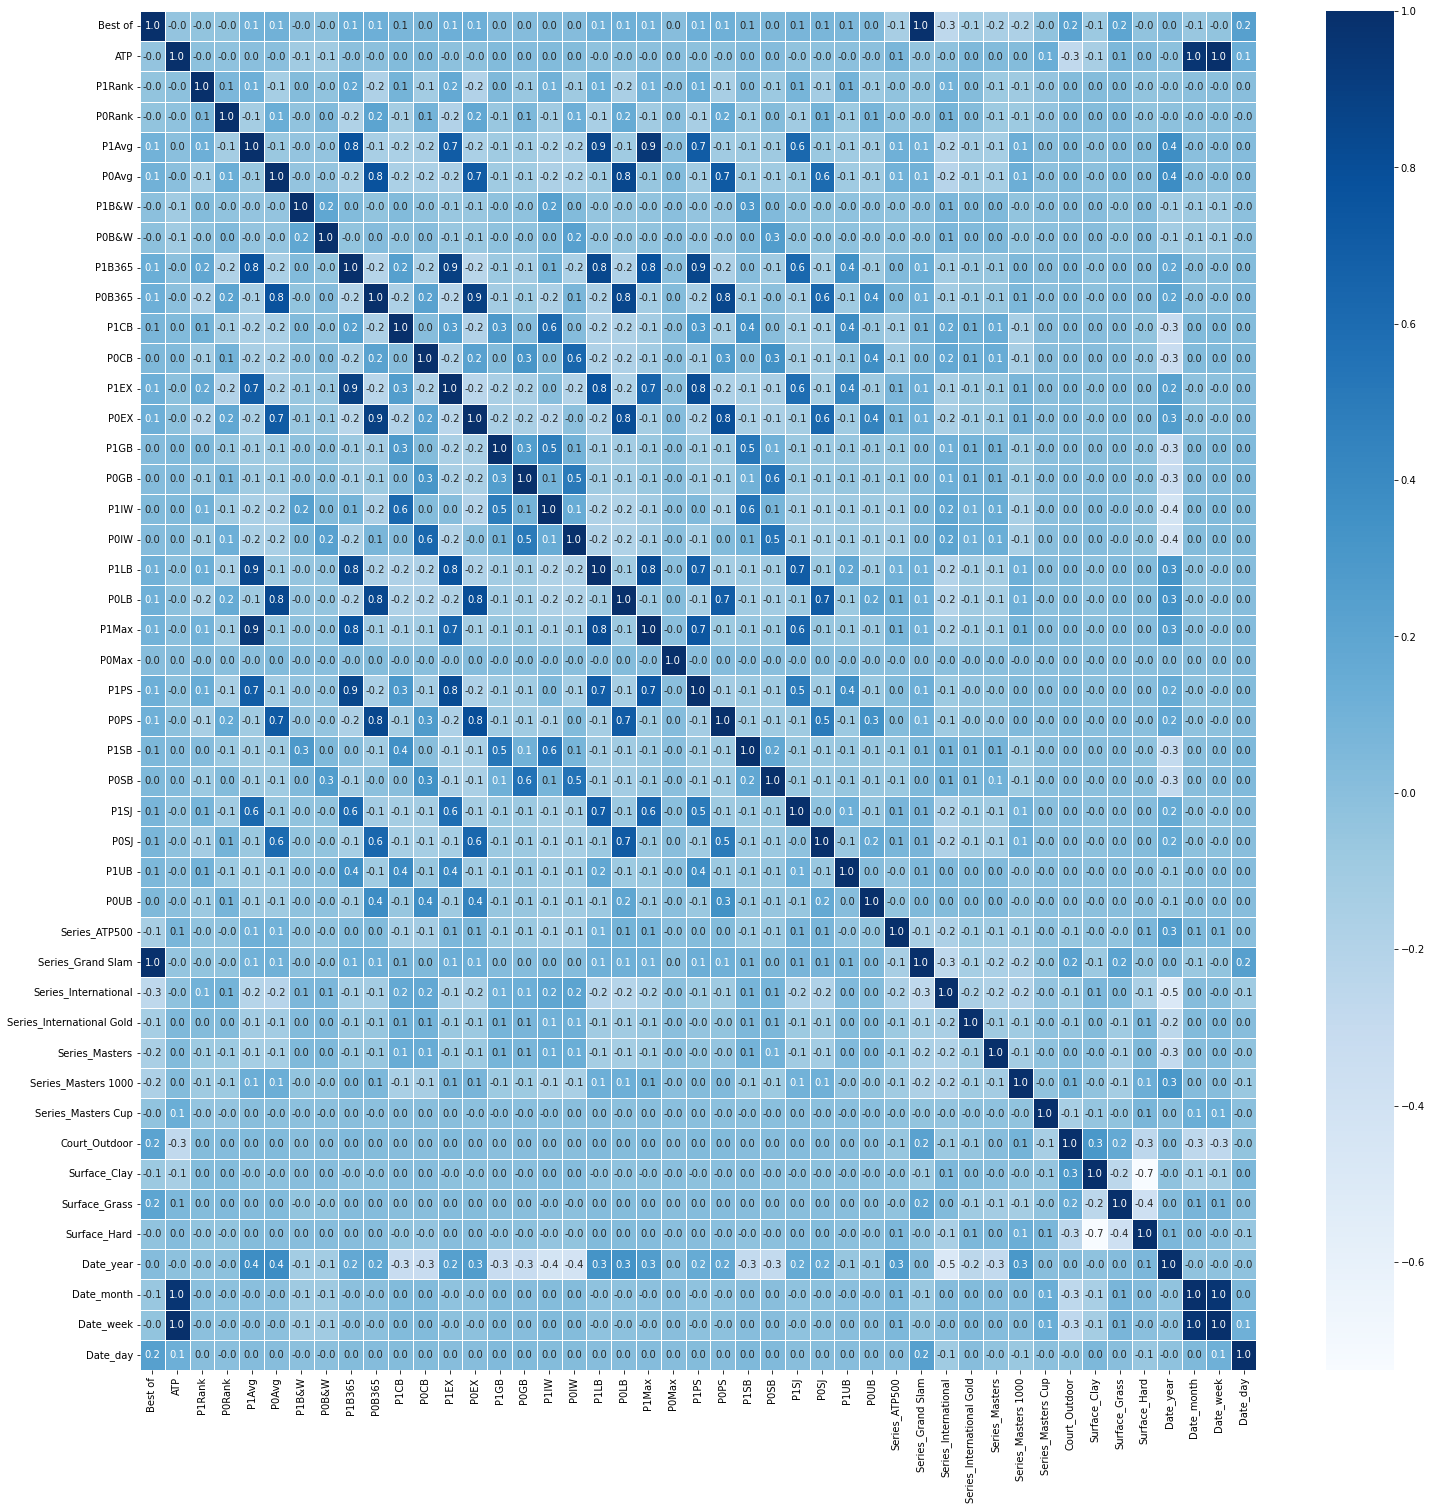

In [49]:
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(df_atp.drop("output", axis=1).corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="Blues")

We can reduce the dimentionality by removing a feature from each high correlated pair of features (as they would bring the same trend to the model) as follows:


In [43]:
df_atp.drop(['P1EX', 'P0EX', 'P1LB', 'P0LB', 'P1Max', 'P1PS', 'P0PS', 'Series_Grand Slam', 'Date_month', 'Date_week'], axis=1, inplace=True)
df_atp

,Best of,ATP,output,P1Rank,P0Rank,P1Avg,P0Avg,P1B&W,P0B&W,P1B365,...,Series_International Gold,Series_Masters,Series_Masters 1000,Series_Masters Cup,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Date_year,Date_day
0,3,1,0,77.0,63.0,1.00,1.00,1.0,1.0,1.00,...,0,0,0,0,1,0,0,1,2000,3
1,3,1,1,5.0,56.0,1.00,1.00,1.0,1.0,1.00,...,0,0,0,0,1,0,0,1,2000,3
2,3,1,1,40.0,655.0,1.00,1.00,1.0,1.0,1.00,...,0,0,0,0,1,0,0,1,2000,3
3,3,1,0,87.0,65.0,1.00,1.00,1.0,1.0,1.00,...,0,0,0,0,1,0,0,1,2000,3
4,3,1,0,198.0,81.0,1.00,1.00,1.0,1.0,1.00,...,0,0,0,0,1,0,0,1,2000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,3,67,1,5.0,10.0,1.38,3.14,1.0,1.0,1.36,...,0,0,0,1,0,0,0,1,2018,16
52294,3,67,1,1.0,7.0,1.17,5.14,1.0,1.0,1.20,...,0,0,0,1,0,0,0,1,2018,16
52295,3,67,1,5.0,3.0,3.14,1.38,1.0,1.0,3.20,...,0,0,0,1,0,0,0,1,2018,17
52296,3,67,1,1.0,6.0,1.12,6.52,1.0,1.0,1.11,...,0,0,0,1,0,0,0,1,2018,17


In [44]:
df_atp.to_csv("Cleaned_data.csv")

In [84]:
predicted_year = 2017

df_train = df_atp.iloc[df_atp[df_atp["Date_year"] != predicted_year].index]
df_test = df_atp.iloc[df_atp[df_atp["Date_year"] == predicted_year].index]

X_train = df_train.drop(["output"], axis=1)
y_train = df_train["output"]

X_test = df_test.drop(["output"], axis=1)
y_test = df_test["output"]

print("Training Set Shape: ",X_train.shape,  y_train.shape)
print("Test Set Shape:     ",X_test.shape,  y_test.shape)

Training Set Shape:  (49663, 35) (49663,)
Test Set Shape:      (2635, 35) (2635,)


In [93]:
#applying decision tree algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model = tree.DecisionTreeClassifier(min_impurity_decrease=0,max_depth=5,random_state=100)    
model.fit(X_train, y_train)   #fitting our model
y_pred=model.predict(X_test)   # evaluating our model
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.6747628083491461


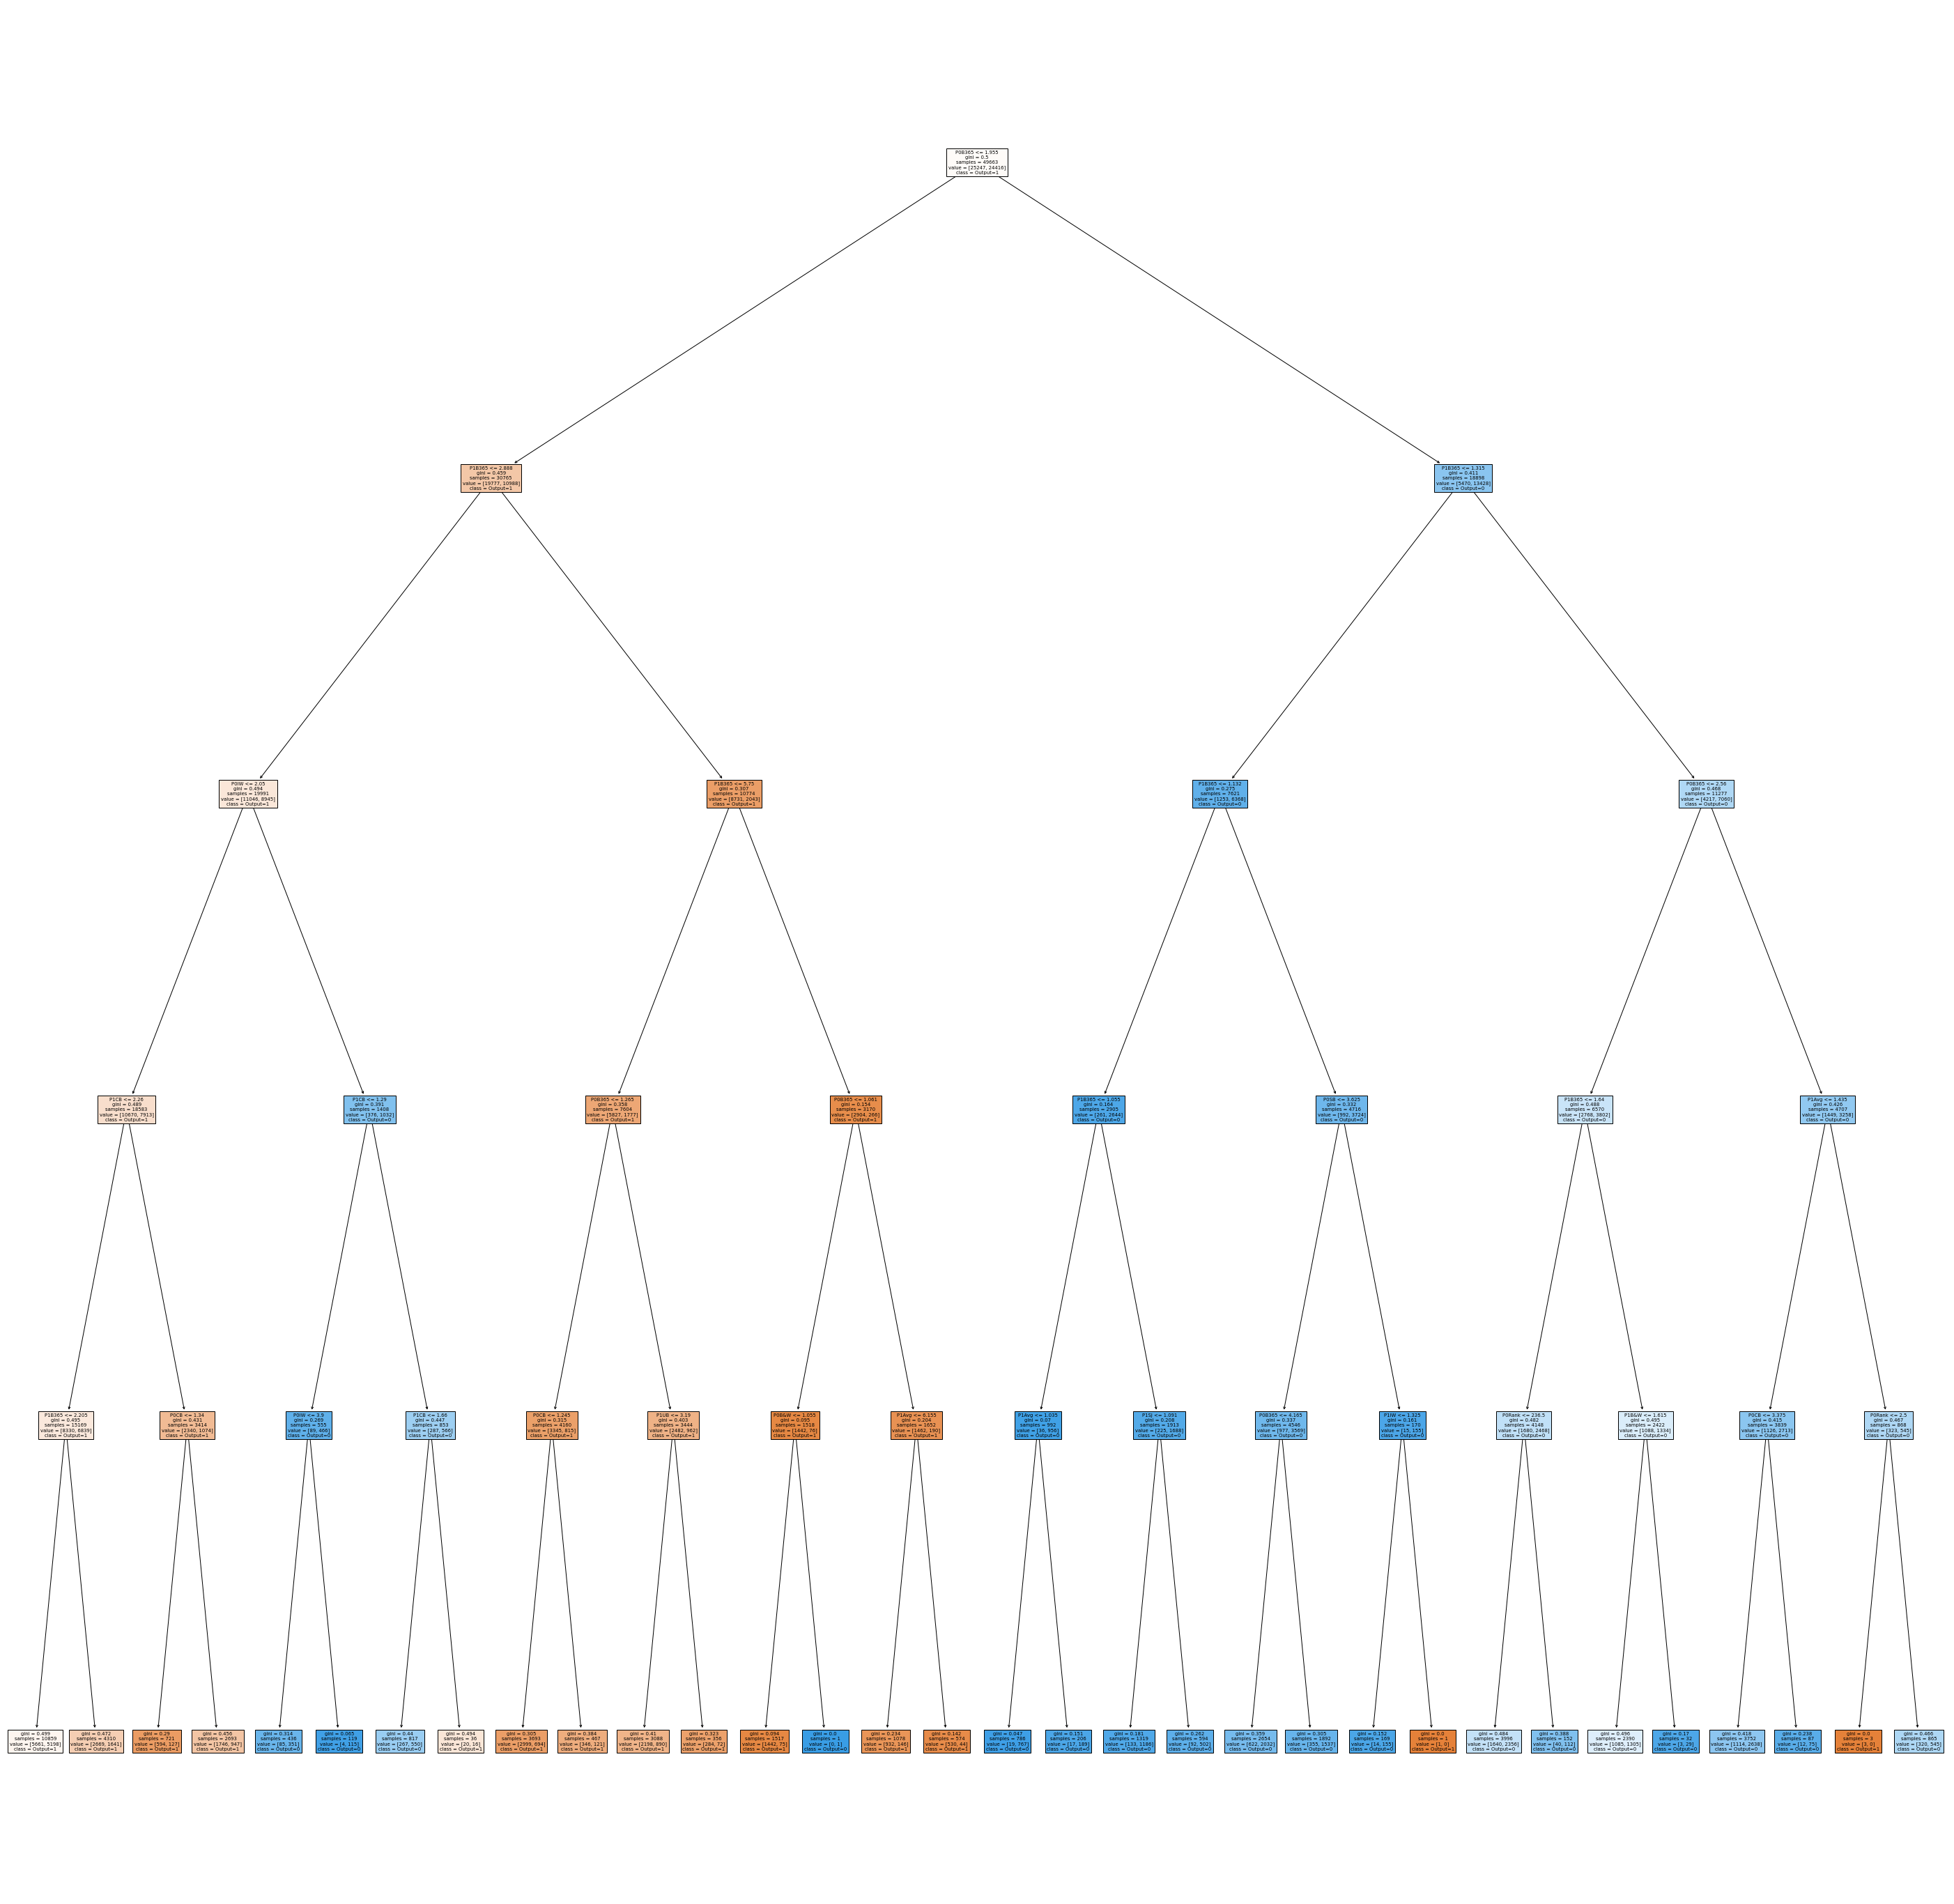

In [57]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(model, 
                   feature_names=X_train.columns.values.tolist(),  
                   class_names=['Output=1', 'Output=0'], filled=True)


fig.savefig("tree.png") 

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1355
           1       0.67      0.65      0.66      1280

    accuracy                           0.67      2635
   macro avg       0.67      0.67      0.67      2635
weighted avg       0.67      0.67      0.67      2635



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

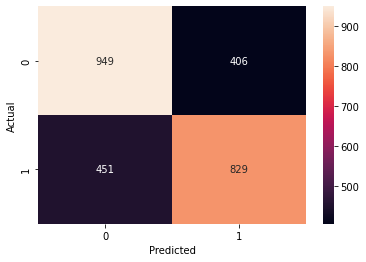

In [59]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True,fmt="d")

In [60]:
roc_auc_score(y_test, y_pred)

0.6740126268450185

In [61]:
roc_curve(y_test, y_pred, pos_label=None, sample_weight=None, drop_intermediate=True)

(array([0.      , 0.299631, 1.      ]),
 array([0.        , 0.64765625, 1.        ]),
 array([2, 1, 0]))

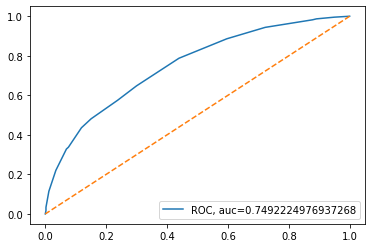

In [62]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.plot([1,0],[1,0], linestyle='--')
plt.legend(loc=4)
plt.show()

Model 2: KNN model

In [97]:
model_2= KNeighborsClassifier(55, n_jobs=-1)
model_2.fit(X_train, y_train)   #fitting our model
y_pred_2=model_2.predict(X_test)   # evaluating our model
print("score:{}".format(accuracy_score(y_test, y_pred_2)))

score:0.6436432637571158


In [98]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1355
           1       0.63      0.67      0.64      1280

    accuracy                           0.64      2635
   macro avg       0.64      0.64      0.64      2635
weighted avg       0.64      0.64      0.64      2635



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

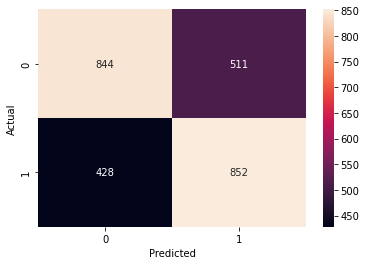

In [99]:
confusion_matrix_2 = pd.crosstab(y_test, y_pred_2, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_2, annot=True, fmt="d")

In [100]:
roc_auc_score(y_test, y_pred_2)

0.6442516143911439

In [101]:
roc_curve(y_test, y_pred_2, pos_label=None, sample_weight=None, drop_intermediate=True)

(array([0.        , 0.37712177, 1.        ]),
 array([0.      , 0.665625, 1.      ]),
 array([2, 1, 0]))

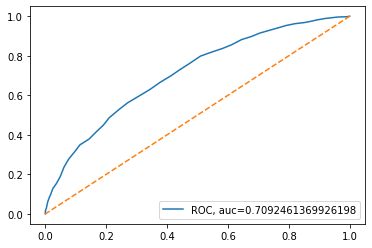

In [103]:
y_pred_proba_2 = model_2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_2)
auc = metrics.roc_auc_score(y_test, y_pred_proba_2)
plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
plt.plot([1,0],[1,0], linestyle='--')
plt.legend(loc=4)
plt.show()

#**Results Discussion:**
The Receiver Operating Characteristic (ROC) curve is a visual representation of how well our binary classification model performed. In this case we are using both Decision Tree classifier as well as KNN to perform the classification on whether player1 or player2 won a given match in 2017.   
The model performance is determined by looking at the area under the ROC curve (or AUC), in our case the AUC=0.749 for the Decision Tree Classifier and AUC= 0.709 for the KNN classifier which demonstartes that the model performed relatively good compared to the best possible AUC is 1 while the worst is 0.5.   
We can also visualize through the confusion matrix that the Decision Tree Classifier has a better recall compared to the KNN model, with a 70% recall for the Lost class for model 1 and 62% for model 2, but the second model performed slightly better in the Won class with 67% as compared to 65% to the decision tree model.  
Also, the f1-score give us a better intuition on the performance of the model compared to only the recall or the precision since it combines both last metrics. The DT model has a 67% accuracy on average compared to the KNN model with 64% average f1-score accuracy.  
Overall, the classification for Predicting the outcome for each ATP tennis game during the year 2017 is performed and there is definetly a room of improvement to inhance the accuracy of the proposed models.
